# Detecting co-moving housing markets and modeling relative price dynamics across U.S. cities

## Overview

This project studies relative behavior across U.S. housing markets rather than absolute price levels or point forecasts. The core objective is to identify which markets tend to move together, when they diverge, and whether those divergences appear temporary (cyclical) or structural (persistent).

Instead of predicting prices, the framework focuses on co-movement, divergence, and regime context, providing a diagnostic lens for understanding regional housing dynamics.

## Core Question

> Which housing markets usually move together, when do they diverge, and what can those divergences tell us about cyclical versus structural differences across regions?

## Data Description

The project uses time-series housing market data at the city / region level, augmented with:

- Year-over-year (YoY) growth rates
- Market identifiers (city, state, region_id)
- Observation counts for data quality control

All analysis is conducted on growth rates, not price levels, to ensure comparability across markets of different sizes.

In [2]:
from __future__ import annotations

import re
import math
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

%matplotlib inline

## Cleaning and augmentation

In [3]:
# Load raw sales price data for each city/region
cp_raw = pd.read_csv("data/raw/Sale_Prices_City.csv")
cp_raw.head()

Unnamed: 0  RegionID   RegionName   StateName  SizeRank   2008-03  \
0           0      6181     New York    New York         1       NaN   
1           1     12447  Los Angeles  California         2  507600.0   
2           2     39051      Houston       Texas         3  138400.0   
3           3     17426      Chicago    Illinois         4  325100.0   
4           4      6915  San Antonio       Texas         5  130900.0   

    2008-04   2008-05   2008-06   2008-07  ...   2019-06   2019-07   2019-08  \
0       NaN       NaN       NaN       NaN  ...  563200.0  570500.0  572800.0   
1  489600.0  463000.0  453100.0  438100.0  ...  706800.0  711800.0  717300.0   
2  135500.0  132200.0  131000.0  133400.0  ...  209700.0  207400.0  207600.0   
3  314800.0  286900.0  274600.0  268500.0  ...  271500.0  266500.0  264900.0   
4  131300.0  131200.0  131500.0  131600.0  ...  197100.0  198700.0  200200.0   

    2019-09   2019-10   2019-11   2019-12   2020-01   2020-02   2020-03  
0  569900.0  560800.0  571500.0  575100.0  571700.0  568300.0  573600.0  
1  714100.0  711900.0  718400.0  727100.0  738200.0  760200.0       NaN  
2  207000.0  211400.0  211500.0  217700.0  219200.0  223800.0       NaN  
3  265000.0  264100.0  264300.0  270000.0  281400.0  302900.0  309200.0  
4  200800.0  203400.0  203800.0  205400.0  205400.0  208300.0       NaN  

[5 rows x 150 columns]

In [4]:
def clean_names(cols):
    
    out = []

    for c in cols:
        
        c = str(c)

        # Split CamelCase: fooBar -> foo_Bar
        c = re.sub(r"([a-z0-9])([A-Z])", r"\1_\2", c)

        # Split letter/number boundaries: foo1 -> foo_1, 1bar -> 1_bar
        c = re.sub(r"([A-Za-z])([0-9])", r"\1_\2", c)
        c = re.sub(r"([0-9])([A-Za-z])", r"\1_\2", c)

        # 3) Lowercase all and strip empy spaces
        c = c.lower().strip()

        # Replace non-alphanumeric with underscore
        c = re.sub(r"[^a-z0-9]+", "_", c)

        # Collapse multiple underscores
        c = re.sub(r"_+", "_", c)

        # Trim trailing/leading underscores
        c = c.strip("_")

        out.append(c)

    return out

def parse_year_month(s):
    """
    Parse year-month strings like:
      '2025_04'
      '2025.04'
      'x2025_04'
      'x2025.04'
    into pandas Timestamp (YYYY-MM-01).
    """
    if pd.isna(s):
        return pd.NaT

    s = str(s)

    # Remove leading 'x' if present
    s = re.sub(r"^x", "", s)

    # Normalize separators to '-'
    s = s.replace("_", "-").replace(".", "-")

    # Parse as year-month; pandas assigns day=1
    return pd.to_datetime(s, format="%Y-%m", errors="coerce")

def clean_city_prices(df: pd.DataFrame) -> pd.DataFrame:

    # Copy dataframe
    df = df.copy()

    # Drop unwanted index column (if present)
    df = df.drop(columns=["Unnamed: 0"], errors="ignore")

    # Clean column names
    df.columns = clean_names(df.columns)

    # Define id_cols for pivot
    id_cols = ["region_id", "region_name", "state_name", "size_rank"]
    missing = [c for c in id_cols if c not in df.columns]
    
    if missing:
        raise KeyError(f"Missing expected id columns after clean_names(): {missing}")

    df_long = df.melt(
        id_vars = id_cols,
        var_name = "date",
        value_name = "sale_price"
    )

    # Fix date parsing due to underscore
    df_long["date"] = df_long["date"].map(parse_year_month)

    # Convert metadata columns to categorical data types
    df_long["region_id"] = df_long["region_id"].astype("category")
    df_long["region_name"] = df_long["region_name"].astype("category")
    df_long["state_name"] = df_long["state_name"].astype("category")

    # Return
    return df_long

cp_clean = clean_city_prices(cp_raw)
cp_clean.head()

region_id  region_name  state_name  size_rank       date  sale_price
0      6181     New York    New York          1 2008-03-01         NaN
1     12447  Los Angeles  California          2 2008-03-01    507600.0
2     39051      Houston       Texas          3 2008-03-01    138400.0
3     17426      Chicago    Illinois          4 2008-03-01    325100.0
4      6915  San Antonio       Texas          5 2008-03-01    130900.0

In [5]:
# Augment pricing data with additional features
def augment_city_prices(df: pd.DataFrame) -> pd.DataFrame:
    
    df = df.copy()

    # Sort on region and date to ensure proper order
    df = df.sort_values(["region_id", "date"])

    # Apply to each region independently
    g = df.groupby("region_id", sort=False)

    # YoY and MoM growth
    df["yoy_growth"] = 100 * (df["sale_price"] / g["sale_price"].shift(12) - 1)
    df["mom_growth"] = 100 * (df["sale_price"] / g["sale_price"].shift(1) - 1)

    # # Smoothed YoY and MoM with monthly rolling averages
    df["yoy_3m_avg"] = g["yoy_growth"].apply(lambda s: s.rolling(3, min_periods=3).mean()).reset_index(level=0, drop=True)
    df["mom_3m_avg"] = g["mom_growth"].apply(lambda s: s.rolling(3, min_periods=3).mean()).reset_index(level=0, drop=True)
    df["mom_6m_avg"] = g["mom_growth"].apply(lambda s: s.rolling(6, min_periods=6).mean()).reset_index(level=0, drop=True)

    # # Define initial sale price to compute cumulative growth
    df["base_price"] = g["sale_price"].transform(lambda s: s.dropna().iloc[0] if s.notna().any() else np.nan)

    # Compute cumulative_growth
    df["cumulative_growth"] = 100 * (df["sale_price"] / df["base_price"] - 1)

    # Compute acceleration
    df["yoy_accel"] = df["yoy_growth"] - g["yoy_growth"].shift(1)
    df["mom_accel"] = df["mom_growth"] - g["mom_growth"].shift(1)

    # Log prices and returns
    df["log_price"] = np.log(df["sale_price"])
    df["log_mom_return"] = g["log_price"].diff(1)
    df["log_yoy_return"] = g["log_price"].diff(12)

    return df

cp_aug = augment_city_prices(cp_clean)
cp_aug.head()

/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/4257913364.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby("region_id", sort=False)


region_id region_name state_name  size_rank       date  sale_price  \
3392       3305    Accokeek   Maryland       3393 2008-03-01         NaN   
7120       3305    Accokeek   Maryland       3393 2008-04-01         NaN   
10848      3305    Accokeek   Maryland       3393 2008-05-01         NaN   
14576      3305    Accokeek   Maryland       3393 2008-06-01         NaN   
18304      3305    Accokeek   Maryland       3393 2008-07-01         NaN   

       yoy_growth  mom_growth  yoy_3m_avg  mom_3m_avg  mom_6m_avg  base_price  \
3392          NaN         NaN         NaN         NaN         NaN    259000.0   
7120          NaN         NaN         NaN         NaN         NaN    259000.0   
10848         NaN         NaN         NaN         NaN         NaN    259000.0   
14576         NaN         NaN         NaN         NaN         NaN    259000.0   
18304         NaN         NaN         NaN         NaN         NaN    259000.0   

       cumulative_growth  yoy_accel  mom_accel  log_price  log_mom_return  \
3392                 NaN        NaN        NaN        NaN             NaN   
7120                 NaN        NaN        NaN        NaN             NaN   
10848                NaN        NaN        NaN        NaN             NaN   
14576                NaN        NaN        NaN        NaN             NaN   
18304                NaN        NaN        NaN        NaN             NaN   

       log_yoy_return  
3392              NaN  
7120              NaN  
10848             NaN  
14576             NaN  
18304             NaN

## Correlation of markets for pair selection

In [6]:
# Correlation of YoY growth to identify region/city market pairs
def compute_corr_n(df, date_col = "date", region_col = "region_id", value_col = "yoy_growth"):

    def overlap_counts(wide: pd.DataFrame) -> pd.DataFrame:
        m = wide.notna().to_numpy(dtype=np.int32)   # 0/1 matrix, shape (T, N)
        n = m.T @ m                                 # shape (N, N), integer counts
        return pd.DataFrame(n, index=wide.columns, columns=wide.columns)

    # Pivot wide for correlation
    wide = df.pivot(index = date_col, columns = region_col, values = value_col).sort_index()

    # Correlation matrix (pairwise complete obs by default)
    corr = wide.corr()

    # Number of overlapping observations
    n_obs = overlap_counts(wide)

    return corr, n_obs

yoy_corr, yoy_n_obs = compute_corr_n(cp_aug)

In [7]:
# Subset to only highly-correlated markets (0.8) with at least 100 months of data (i.e. strong support)

# Define thresholds
r_thresh = 0.8
n_obs_thresh = 100

# Define mask
mask = (yoy_corr.abs() >= r_thresh) & (yoy_n_obs >= n_obs_thresh)

# Subset objects
yoy_corr_sub = yoy_corr.where(mask)
yoy_n_obs_sub = yoy_n_obs.where(mask)

In [8]:
# Convert to long-form dataframe
corr_long = (
    yoy_corr
        .where(mask)
        .rename_axis(index = "x", columns = "y")
        .stack(dropna=True)
        .rename("r")
        .reset_index()
)

n_long = (
    yoy_n_obs
        .where(mask)
        .rename_axis(index = "x", columns = "y")
        .stack(dropna=True)
        .rename("n_obs")
        .reset_index()
)

# Merge correlation and value counts into same dataframe
corr_n_long = corr_long.merge(n_long, on = ["x", "y"], how = "inner")

# Filter out perfectly-correlated pairs (i.e. self-correlations)
corr_n_long = corr_n_long[corr_n_long["r"] != 1]

# View result
corr_n_long.head()

/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/2364491660.py:6: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=True)
/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/2364491660.py:15: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=True)


x      y         r  n_obs
2  3418  17384  0.811469  132.0
3  3418  21417  0.801566  133.0
4  3418  26366  0.823589  132.0
5  3418  26483  0.800991  133.0
6  3418  33501  0.824117  133.0

## Calculation of pair spreads and z-scores

In [9]:
# Compute pair spreads and z-scores for pairs in corr_n_long
# Using log-prices for spread computation
def make_pair_spreads(
    pairs: pd.DataFrame,
    df: pd.DataFrame,
    *,
    date_col: str = "date",
    region_col: str = "region_id",
    value_col: str = "log_price",
    x_col: str = "x",
    y_col: str = "y",
    pair_id_col: str | None = None,
    # z-score options
    zscore: str = "global",          # "global" or "rolling" or "none"
    rolling_window: int = 36,        # used if zscore="rolling"
    min_periods: int | None = None,  # defaults to rolling_window
    ddof: int = 1,
    eps: float = 1e-12,
) -> pd.DataFrame | None:
    """
    Build per-pair spreads (X - Y) and z-scores for a panel of time series.

    Returns LONG dataframe:
      one row per (pair_id, date)

    Required columns:
      pairs: [x_col, y_col] (optionally r, n_obs etc to be carried through)
      df:    [date_col, region_col, value_col]

    Notes:
      - For relative value, prefer value_col="log_price" then spread is log(price_x/price_y).
      - For co-movement screening, value_col="yoy_growth" is fine but not “relative value canonical”.
    """
    if pairs is None or pairs.empty:
        return None

    # -----------------------------
    # Pivot once: wide[T, N]
    # -----------------------------
    wide = (
        df.pivot(index=date_col, columns=region_col, values=value_col)
          .sort_index()
    )
    wide.columns = wide.columns.astype(str)

    cols = wide.columns
    dates = wide.index.to_numpy()
    A = wide.to_numpy(dtype=float)
    T, N = A.shape

    # -----------------------------
    # Pair definitions
    # -----------------------------
    px = pairs[x_col].astype(str).to_numpy()
    py = pairs[y_col].astype(str).to_numpy()
    P = len(pairs)

    ix = cols.get_indexer(px)
    iy = cols.get_indexer(py)

    # Allocate X, Y: [T, P]
    X = np.full((T, P), np.nan, dtype=float)
    Y = np.full((T, P), np.nan, dtype=float)

    okx = ix >= 0
    oky = iy >= 0
    ok = okx & oky

    if ok.any():
        X[:, ok] = A[:, ix[ok]]
        Y[:, ok] = A[:, iy[ok]]

    # Spread
    spread = X - Y  # [T, P]

    # Count valid obs per pair from the spread series
    valid = np.isfinite(spread)
    n_valid = valid.sum(axis=0).astype(int)  # [P,]

    # -----------------------------
    # Z-score
    # -----------------------------
    if zscore == "none":
        mu = np.full(P, np.nan)
        sd = np.full(P, np.nan)
        z = np.full_like(spread, np.nan)

    elif zscore == "global":
        mu = np.nanmean(spread, axis=0)  # [P,]
        sd = np.nanstd(spread, axis=0, ddof=ddof)  # [P,]

        # Avoid division by ~0
        sd_safe = np.where(np.isfinite(sd) & (sd > eps), sd, np.nan)
        z = (spread - mu) / sd_safe

    elif zscore == "rolling":
        # Rolling z-score per pair (done via pandas over columns; slower than pure NumPy,
        # but still fine for hundreds of cities and a few thousand pairs)
        # If performance becomes an issue, we can switch to a pure NumPy rolling impl.
        if min_periods is None:
            min_periods = rolling_window

        spread_df = pd.DataFrame(spread, index=wide.index, columns=np.arange(P))
        roll_mu = spread_df.rolling(rolling_window, min_periods=min_periods).mean()
        roll_sd = spread_df.rolling(rolling_window, min_periods=min_periods).std(ddof=ddof)

        z_df = (spread_df - roll_mu) / roll_sd.replace(0.0, np.nan)
        z = z_df.to_numpy(dtype=float)

        # For output consistency, still provide "global" mu/sd as pair-level summaries
        mu = np.nanmean(spread, axis=0)
        sd = np.nanstd(spread, axis=0, ddof=ddof)

    else:
        raise ValueError("zscore must be one of {'global','rolling','none'}")

    # -----------------------------
    # Pair IDs and output
    # -----------------------------
    if pair_id_col and pair_id_col in pairs.columns:
        pair_id = pairs[pair_id_col].astype(str).to_numpy()
    else:
        pair_id = (pairs[x_col].astype(str) + " vs " + pairs[y_col].astype(str)).to_numpy()

    # Flatten pair-major
    Sv = spread.T.ravel()
    Zv = z.T.ravel()
    Xv = X.T.ravel()
    Yv = Y.T.ravel()

    out = pd.DataFrame({
        "pair_id":   np.repeat(pair_id, T),
        "date":      np.tile(dates, P),
        "x_region":  np.repeat(px, T),
        "y_region":  np.repeat(py, T),
        "x_value":   Xv,
        "y_value":   Yv,
        "spread":    Sv,
        "spread_mu": np.repeat(mu, T),
        "spread_sd": np.repeat(sd, T),
        "z":         Zv,
        "n_valid":   np.repeat(n_valid, T),
    })

    # Carry through any extra pair metadata columns if present
    passthrough_cols = [c for c in pairs.columns if c not in {x_col, y_col}]
    for c in passthrough_cols:
        out[c] = np.repeat(pairs[c].to_numpy(), T)

    return out

pair_spreads = make_pair_spreads(
    pairs = corr_n_long,
    df = cp_aug,
    date_col = "date",
    region_col = "region_id",
    value_col = "log_price",
    x_col = "x",
    y_col = "y",
    zscore = "rolling",
    rolling_window = 36
)

pair_spreads.head()

pair_id       date x_region y_region    x_value    y_value    spread  \
0  3418 vs 17384 2008-03-01     3418    17384  12.538967  12.433607  0.105361   
1  3418 vs 17384 2008-04-01     3418    17384  12.505436  12.385891  0.119545   
2  3418 vs 17384 2008-05-01     3418    17384  12.479529  12.356646  0.122884   
3  3418 vs 17384 2008-06-01     3418    17384  12.515394  12.374549  0.140845   
4  3418 vs 17384 2008-07-01     3418    17384  12.506177  12.378765  0.127413   

   spread_mu  spread_sd   z  n_valid         r  n_obs  
0   0.065329   0.064574 NaN      144  0.811469  132.0  
1   0.065329   0.064574 NaN      144  0.811469  132.0  
2   0.065329   0.064574 NaN      144  0.811469  132.0  
3   0.065329   0.064574 NaN      144  0.811469  132.0  
4   0.065329   0.064574 NaN      144  0.811469  132.0

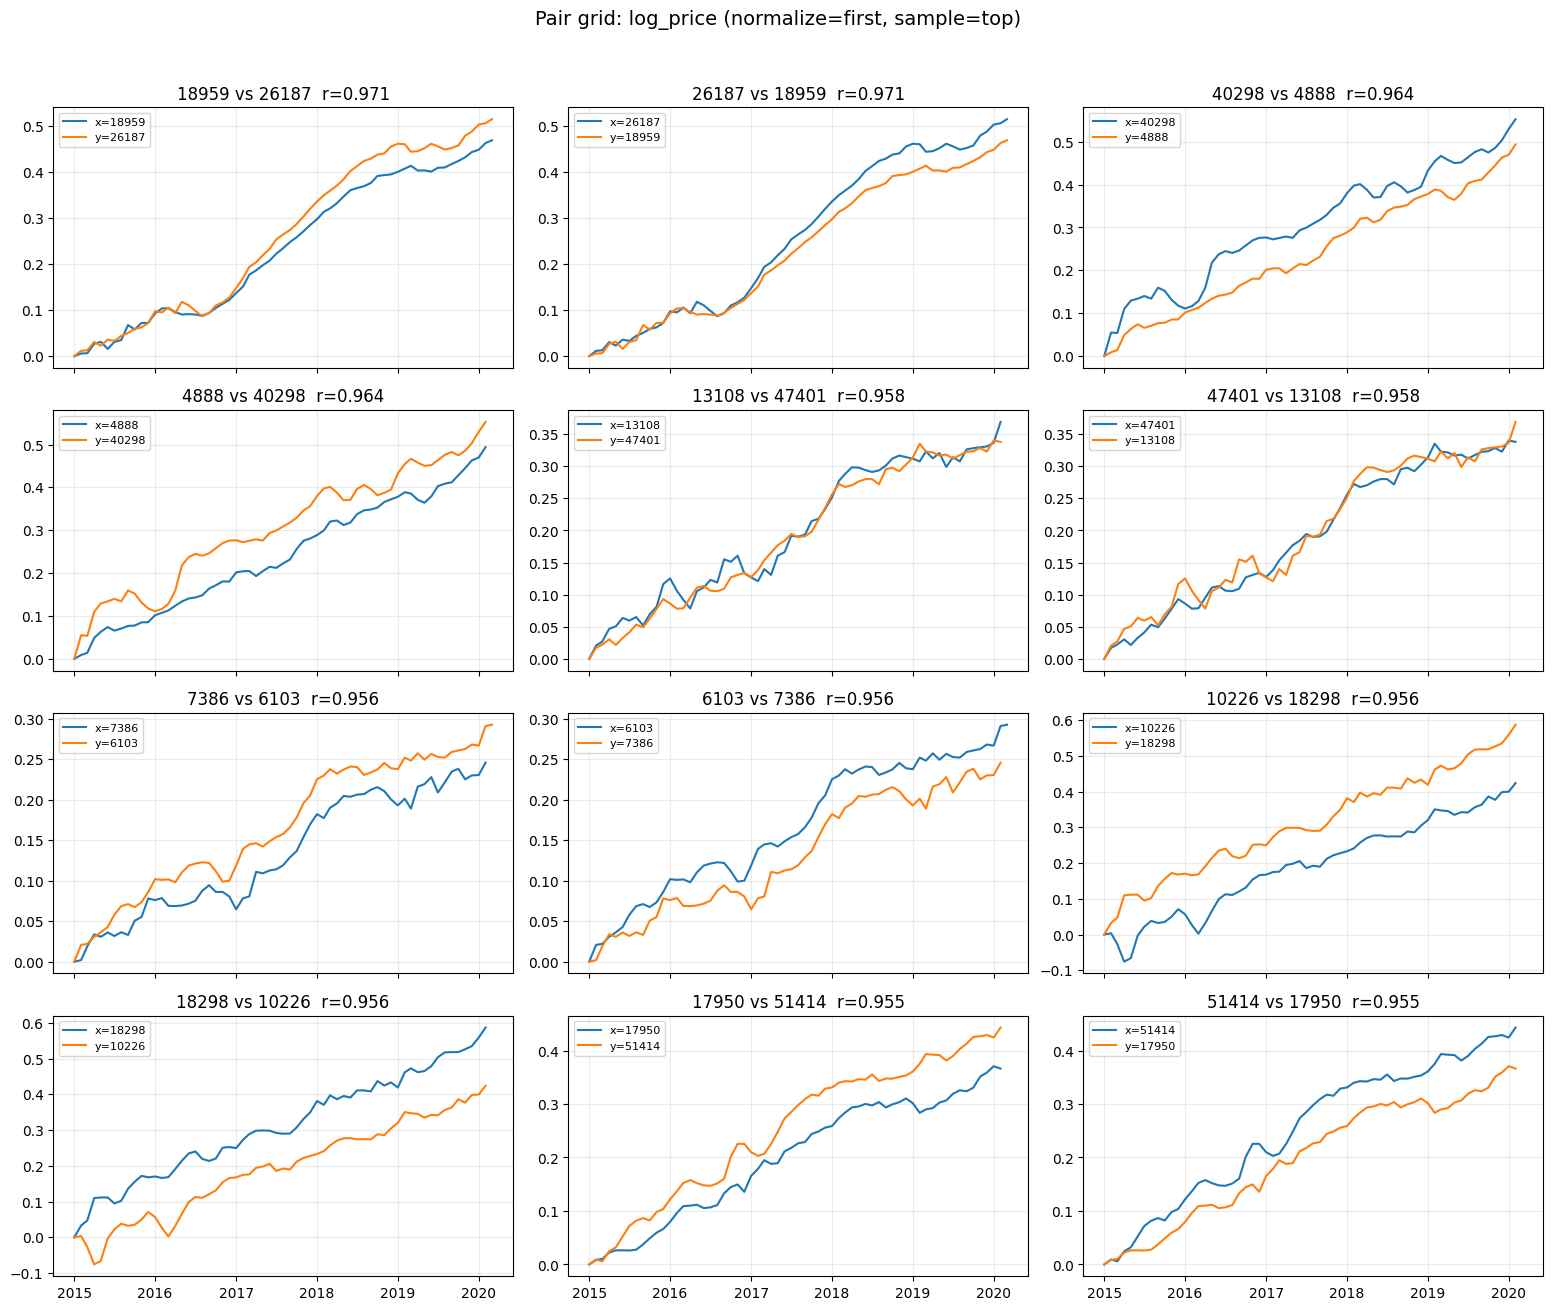

In [11]:
def _canon_region_key(v) -> str:
    """Canonicalize region identifiers so '12345', 12345, '12345.0', 12345.0 all match."""
    if pd.isna(v):
        return ""
    s = str(v).strip()

    # Try to coerce numeric-looking strings to an integer-like string if they are whole numbers
    # e.g., "12345.0" -> "12345"
    try:
        f = float(s)
        if np.isfinite(f) and abs(f - round(f)) < 1e-9:
            return str(int(round(f)))
    except Exception:
        pass

    return s

def plot_pair_grid(
    pairs: pd.DataFrame,
    cp_aug: pd.DataFrame,
    *,
    n_pairs: int = 12,
    seed: int = 7,
    # columns
    date_col: str = "date",
    region_col: str = "region_id",
    value_col: str = "log_price",
    x_col: str = "x",
    y_col: str = "y",
    # sampling
    sample_mode: str = "top",   # {"top", "random"}
    score_col: str = "r",       # used if sample_mode="top"
    ascending: bool = False,
    # filtering
    start: str | pd.Timestamp | None = None,
    end: str | pd.Timestamp | None = None,
    min_obs: int = 36,
    # plotting
    ncols: int = 3,
    figsize: tuple[float, float] | None = None,
    sharex: bool = True,
    sharey: bool = False,
    normalize: str = "none",    # {"none","first","mean"} applied per-series
    suptitle: str | None = None,
) -> tuple[plt.Figure, np.ndarray]:
    """
    Plot a grid of (x,y) pairs where each subplot overlays the two series.
    Robust to region_id dtype issues (e.g., 12345 vs 12345.0).
    """
    if pairs is None or pairs.empty:
        raise ValueError("pairs is empty.")

    df = cp_aug.copy()

    # Date handling + filtering
    df[date_col] = pd.to_datetime(df[date_col])
    if start is not None:
        df = df[df[date_col] >= pd.to_datetime(start)]
    if end is not None:
        df = df[df[date_col] <= pd.to_datetime(end)]

    # Canonicalize region keys in the source data (so pivot columns are canonical)
    df["_region_key_canon"] = df[region_col].map(_canon_region_key)

    # Pivot once
    wide = (
        df.pivot(index=date_col, columns="_region_key_canon", values=value_col)
          .sort_index()
    )

    # Choose pairs
    if sample_mode == "top":
        if score_col not in pairs.columns:
            raise ValueError(f"sample_mode='top' requires score_col='{score_col}' in pairs.")
        chosen = pairs.sort_values(score_col, ascending=ascending).head(n_pairs).copy()
    elif sample_mode == "random":
        rng = np.random.default_rng(seed)
        idx = rng.choice(len(pairs), size=min(n_pairs, len(pairs)), replace=False)
        chosen = pairs.iloc[idx].copy()
    else:
        raise ValueError("sample_mode must be one of {'top','random'}")

    # Canonicalize pair ids
    chosen["_x_canon"] = chosen[x_col].map(_canon_region_key)
    chosen["_y_canon"] = chosen[y_col].map(_canon_region_key)

    # Grid
    P = len(chosen)
    ncols = max(1, int(ncols))
    nrows = math.ceil(P / ncols)

    if figsize is None:
        figsize = (5.2 * ncols, 3.2 * nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, sharey=sharey)
    axes = np.array(axes).reshape(-1)

    def _normalize(s: pd.Series) -> pd.Series:
        if normalize == "none":
            return s
        if normalize == "first":
            first = s.dropna().iloc[0] if s.notna().any() else np.nan
            return s - first
        if normalize == "mean":
            return s - s.mean(skipna=True)
        raise ValueError("normalize must be one of {'none','first','mean'}")

    cols_set = set(wide.columns)

    for i, (_, row) in enumerate(chosen.iterrows()):
        ax = axes[i]
        x_id = row["_x_canon"]
        y_id = row["_y_canon"]

        if (x_id not in cols_set) or (y_id not in cols_set) or (x_id == "") or (y_id == ""):
            ax.set_title(f"{row[x_col]} vs {row[y_col]}\n(missing series)")
            ax.axis("off")
            continue

        sx = wide[x_id]
        sy = wide[y_id]

        overlap = sx.notna() & sy.notna()
        if overlap.sum() < min_obs:
            ax.set_title(f"{row[x_col]} vs {row[y_col]}\n(<{min_obs} overlapping obs)")
            ax.axis("off")
            continue

        sxn = _normalize(sx)
        syn = _normalize(sy)

        ax.plot(sxn.index, sxn.values, label=f"x={row[x_col]}")
        ax.plot(syn.index, syn.values, label=f"y={row[y_col]}")

        score_txt = ""
        if score_col in row.index and pd.notna(row[score_col]):
            score_txt = f"  {score_col}={row[score_col]:.3f}"
        ax.set_title(f"{row[x_col]} vs {row[y_col]}{score_txt}")
        ax.grid(True, alpha=0.25)
        ax.legend(fontsize=8, loc="best")

    for j in range(P, len(axes)):
        axes[j].axis("off")

    if suptitle is None:
        suptitle = f"Pair grid: {value_col} (normalize={normalize}, sample={sample_mode})"
    fig.suptitle(suptitle, y=1.02, fontsize=14)
    fig.tight_layout()

    return fig, axes

fig, axes = plot_pair_grid(
    pairs = corr_n_long,
    cp_aug = cp_aug,
    n_pairs = 12,
    sample_mode = "top",
    score_col = "r",
    value_col = "log_price",
    normalize = "first", # aligns starting levels so shape comparison pops
    ncols = 3,
    start = "2015-01-01"
)

plt.show()

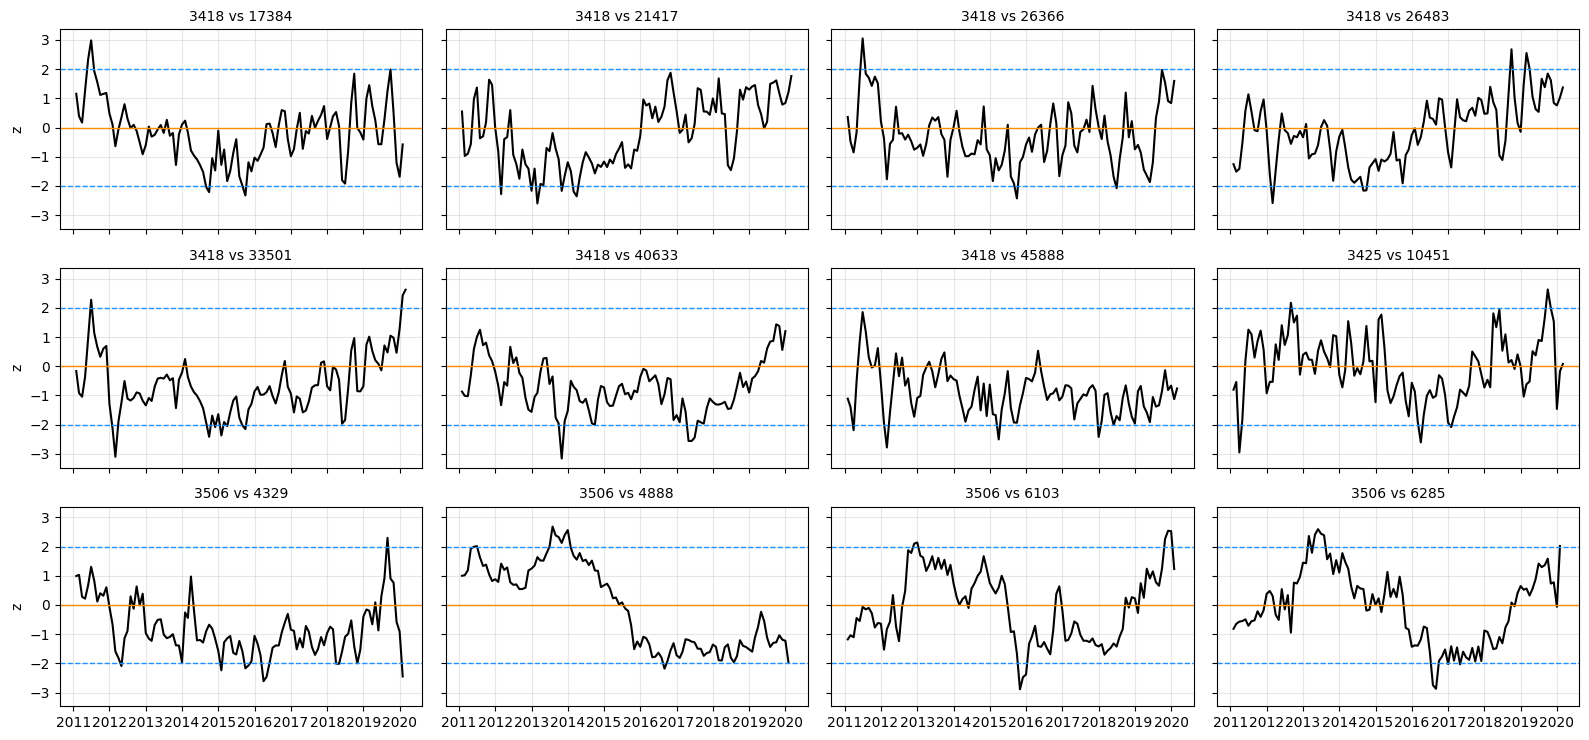

In [12]:
# Plot Z-scores of spreads
def plot_pair_z_grid(
    spreads_df,
    pair_ids=None,
    n_pairs=12,
    ncols=4,
    figsize_per_cell=(4.0, 2.5),
    date_col="date",
    pair_col="pair_id",
    z_col="z",
):
    """
    Plot z-scores for multiple pairs in a grid (small multiples).

    - If pair_ids is None, it plots the first n_pairs unique pairs found.
    - One subplot per pair.
    """
    df = spreads_df.copy()

    # Choose which pairs to plot
    if pair_ids is None:
        pair_ids = df[pair_col].dropna().unique()[:n_pairs]
    else:
        pair_ids = list(pair_ids)[:n_pairs]

    n = len(pair_ids)
    if n == 0:
        raise ValueError("No pair_ids to plot.")

    nrows = math.ceil(n / ncols)

    # Figure sizing: scale by grid size
    figsize = (figsize_per_cell[0] * ncols, figsize_per_cell[1] * nrows)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=True, sharey=True)
    axes = axes.ravel() if n > 1 else [axes]

    for i, pid in enumerate(pair_ids):
        ax = axes[i]
        tmp = df[df[pair_col] == pid].sort_values(date_col)

        ax.plot(tmp[date_col], tmp[z_col], color = "black")
        ax.axhline(0, linewidth=1, color = "darkorange")
        ax.axhline(2, linestyle="--", linewidth=1, color = "dodgerblue")
        ax.axhline(-2, linestyle="--", linewidth=1, color = "dodgerblue")

        ax.set_title(pid, fontsize=10)
        ax.set_ylabel("z" if (i % ncols == 0) else "")
        ax.grid(True, alpha=0.3)

    # Turn off any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    #fig.suptitle("Pair Z-scores (Spread Z)", fontsize=14)
    fig.tight_layout()
    plt.show()

plot_pair_z_grid(pair_spreads)

## Evaluating pair stationarity

In [13]:
def analyze_pair_stationarity(
    pair_spreads: pd.DataFrame,
    *,
    pair_id_col: str = "pair_id",
    date_col: str = "date",
    spread_col: str = "spread",
    min_obs: int = 60,              # require at least ~5 years of monthly data
    adf_regression: str = "c",      # {"c","ct","ctt","n"}: constant / trend / etc...
    adf_autolag: str = "AIC",       # {"AIC","BIC","t-stat",None}
    ddof: int = 1,
) -> pd.DataFrame:
    """
    Per-pair stationarity + mean-reversion summary for log-price spreads.

    Expected input: LONG dataframe with at least:
      - pair_id_col (e.g., "pair_id")
      - date_col    (e.g., "date")
      - spread_col  (e.g., "spread")  # log_price_x - log_price_y

    Outputs one row per pair with:
      - ADF test statistic + p-value
      - AR(1) phi estimate on spread level
      - half-life in months (if 0 < phi < 1)
      - basic spread moments and sample size

    Notes:
      - Use spreads built from log_price (log(price_x/price_y)) for the cleanest interpretation.
      - ADF is sensitive to deterministic trends; choose adf_regression accordingly.
    """
    try:
        from statsmodels.tsa.stattools import adfuller
    except ImportError as e:
        raise ImportError(
            "statsmodels is required for ADF testing. Install with: pip install statsmodels"
        ) from e

    df = pair_spreads[[pair_id_col, date_col, spread_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values([pair_id_col, date_col])

    rows = []

    for pid, g in df.groupby(pair_id_col, sort=False):
        s = g[spread_col].astype(float).to_numpy()

        # Drop NaNs
        mask = np.isfinite(s)
        if mask.sum() < min_obs:
            rows.append({
                pair_id_col: pid,
                "n_obs": int(mask.sum()),
                "date_start": g[date_col].min(),
                "date_end": g[date_col].max(),
                "spread_mean": np.nan,
                "spread_sd": np.nan,
                "adf_stat": np.nan,
                "adf_p": np.nan,
                "adf_lags": np.nan,
                "ar1_phi": np.nan,
                "ar1_intercept": np.nan,
                "half_life_months": np.nan,
                "status": f"insufficient_obs(<{min_obs})",
            })
            continue

        s_series = pd.Series(s[mask])
        spread_mean = float(s_series.mean())
        spread_sd = float(s_series.std(ddof=ddof))

        # --- ADF on spread level ---
        adf_stat = adf_p = adf_lags = np.nan
        status = "ok"
        try:
            adf_out = adfuller(
                s_series.to_numpy(),
                regression=adf_regression,
                autolag=adf_autolag,
            )
            adf_stat = float(adf_out[0])
            adf_p = float(adf_out[1])
            adf_lags = int(adf_out[2])
        except Exception as e:
            status = f"adf_failed: {type(e).__name__}"

        # --- AR(1) on spread: s_t = a + phi * s_{t-1} + eps ---
        # Use the same NaN-filtered series, then form lag pairs.
        y = s_series.to_numpy()[1:]
        x = s_series.to_numpy()[:-1]

        # OLS with intercept (closed form)
        # phi = cov(x,y)/var(x); a = mean(y) - phi*mean(x)
        ar1_phi = ar1_intercept = half_life = np.nan
        try:
            x_mean = float(np.mean(x))
            y_mean = float(np.mean(y))
            var_x = float(np.mean((x - x_mean) ** 2))

            if var_x > 0:
                cov_xy = float(np.mean((x - x_mean) * (y - y_mean)))
                phi = cov_xy / var_x
                a = y_mean - phi * x_mean
                ar1_phi = float(phi)
                ar1_intercept = float(a)

                # Half-life in months for 0 < phi < 1
                # h = ln(0.5)/ln(phi)
                if 0 < phi < 1:
                    half_life = float(np.log(0.5) / np.log(phi))
                else:
                    half_life = np.inf  # indicates non-mean-reverting or oscillatory
        except Exception as e:
            if status == "ok":
                status = f"ar1_failed: {type(e).__name__}"
            else:
                status += f"; ar1_failed: {type(e).__name__}"

        rows.append({
            pair_id_col: pid,
            "n_obs": int(mask.sum()),
            "date_start": g[date_col].min(),
            "date_end": g[date_col].max(),
            "spread_mean": spread_mean,
            "spread_sd": spread_sd,
            "adf_stat": adf_stat,
            "adf_p": adf_p,
            "adf_lags": adf_lags,
            "ar1_phi": ar1_phi,
            "ar1_intercept": ar1_intercept,
            "half_life_months": half_life,
            "status": status,
        })

    out = pd.DataFrame(rows)

    # Helpful “integration” label (tweak thresholds to your taste)
    def _label(row):
        if row["status"] != "ok":
            return "check_status"
        if not np.isfinite(row["adf_p"]):
            return "unknown"
        if row["adf_p"] < 0.05 and np.isfinite(row["half_life_months"]) and row["half_life_months"] < 120:
            return "integrated"
        if row["adf_p"] < 0.10:
            return "weakly_integrated"
        return "non_integrated"

    out["integration_class"] = out.apply(_label, axis=1)

    # Add pair X and Y identifiers for ease of use
    xy = out[pair_id_col].astype(str).str.split(" vs ", expand=True)
    out["x"] = xy[0]
    out["y"] = xy[1]

    # Sort: best candidates first (stationary + faster reversion)
    out = out.sort_values(
        by=["integration_class", "adf_p", "half_life_months", "n_obs"],
        ascending=[True, True, True, False],
    ).reset_index(drop=True)

    return out

pair_stats = analyze_pair_stationarity(
    pair_spreads,
    spread_col = "spread",
    min_obs = 60,
    adf_regression = "ct"
)

pair_stats.head(5)

pair_id  n_obs date_start   date_end  spread_mean  spread_sd  \
0   26469 vs 6884    144 2008-03-01 2020-03-01     1.723300   0.134741   
1   6884 vs 26469    144 2008-03-01 2020-03-01    -1.723300   0.134741   
2  18298 vs 19331    144 2008-03-01 2020-03-01    -0.139247   0.076119   
3  19331 vs 18298    144 2008-03-01 2020-03-01     0.139247   0.076119   
4  10226 vs 40326    144 2008-03-01 2020-03-01     0.036796   0.081014   

   adf_stat         adf_p  adf_lags   ar1_phi  ar1_intercept  \
0 -7.550652  7.792013e-10         9  0.958054       0.071578   
1 -7.550652  7.792013e-10         9  0.958054      -0.071578   
2 -7.352714  2.220711e-09        11  0.910735      -0.013307   
3 -7.352714  2.220711e-09        11  0.910735       0.013307   
4 -7.337678  2.404083e-09        10  0.912603       0.004295   

   half_life_months status integration_class      x      y  
0         16.175888     ok        integrated  26469   6884  
1         16.175888     ok        integrated   6884  26469  
2          7.413037     ok        integrated  18298  19331  
3          7.413037     ok        integrated  19331  18298  
4          7.579160     ok        integrated  10226  40326

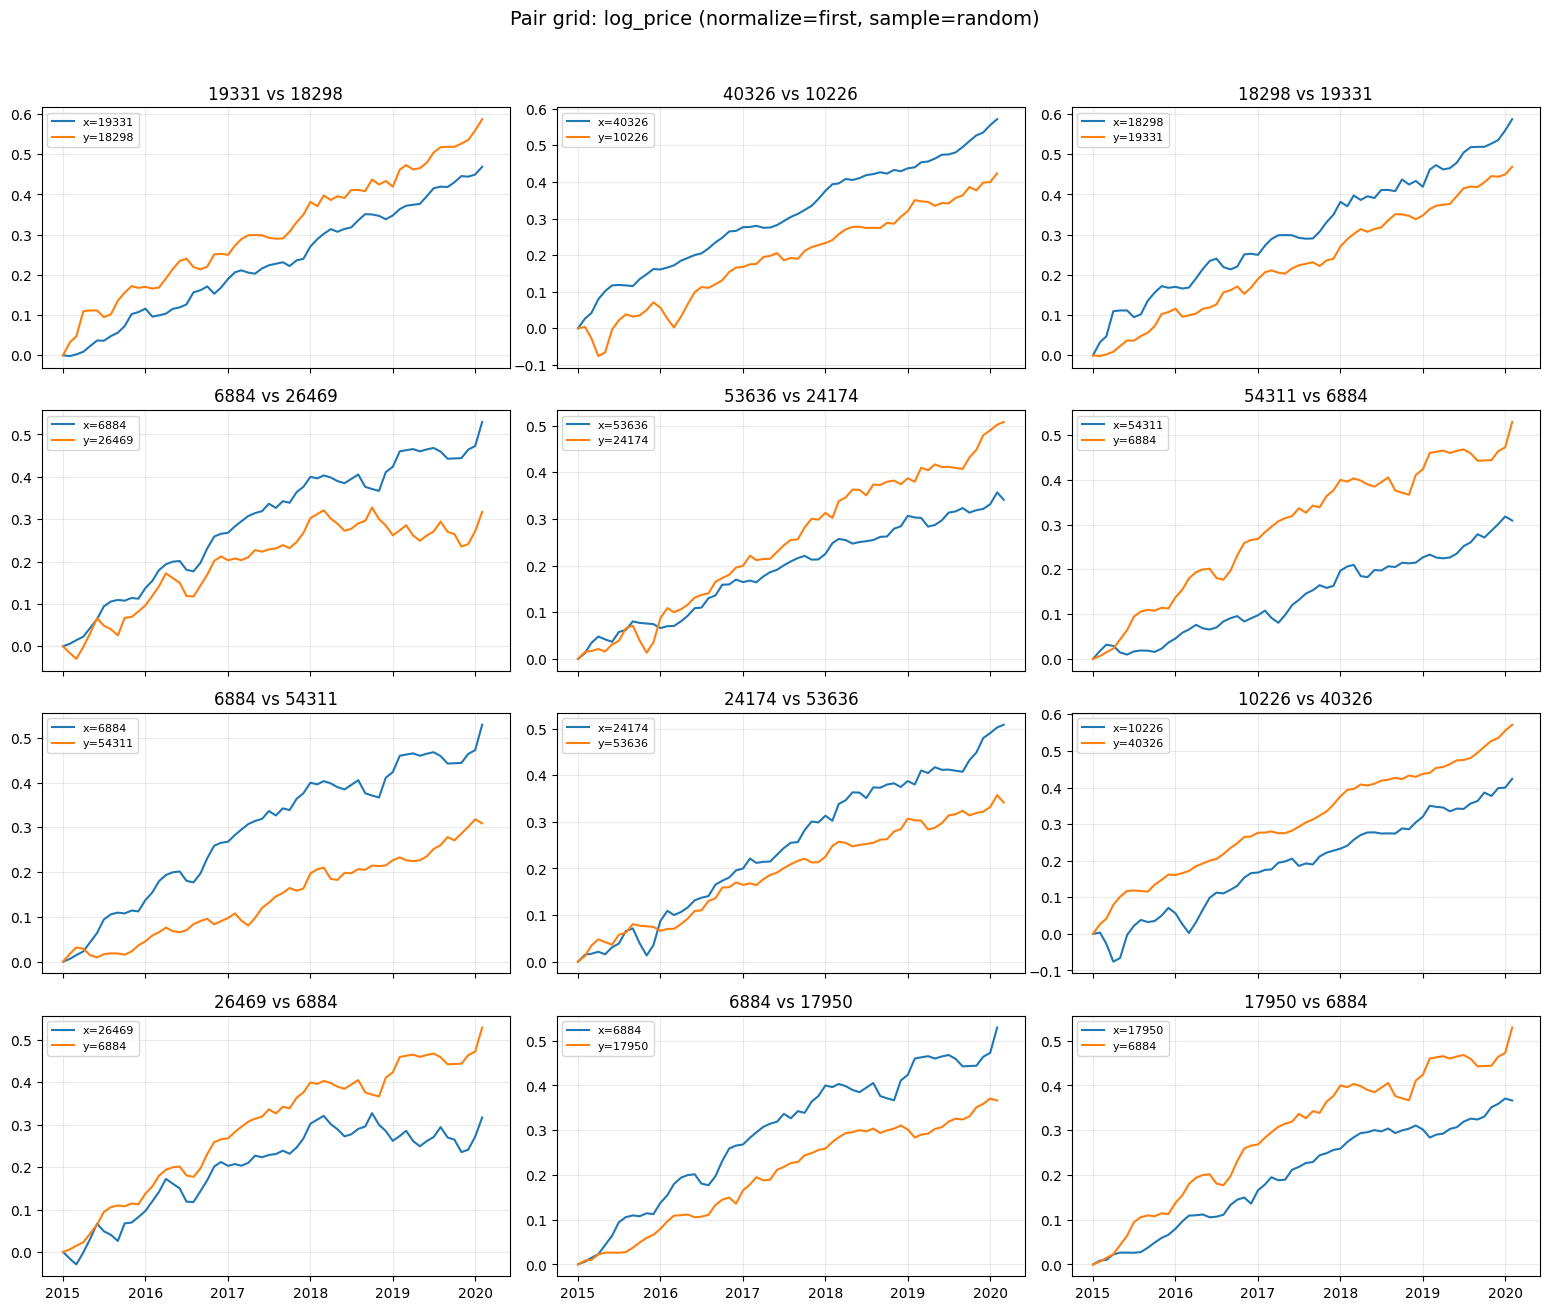

In [14]:
# Select top pairs for plotting
top_pairs = (
    pair_stats
        .query("integration_class == 'integrated'")
        .sort_values(["adf_p", "half_life_months"])
        .head(12)
)

top_pairs_list = top_pairs["pair_id"].to_list()

fig, axes = plot_pair_grid(
    pairs = top_pairs,
    cp_aug = cp_aug,
    n_pairs = len(top_pairs),
    sample_mode = "random",
    score_col = "r",
    value_col = "log_price",
    normalize = "first", # aligns starting levels so shape comparison pops
    ncols = 3,
    start = "2015-01-01"
)

plt.show()

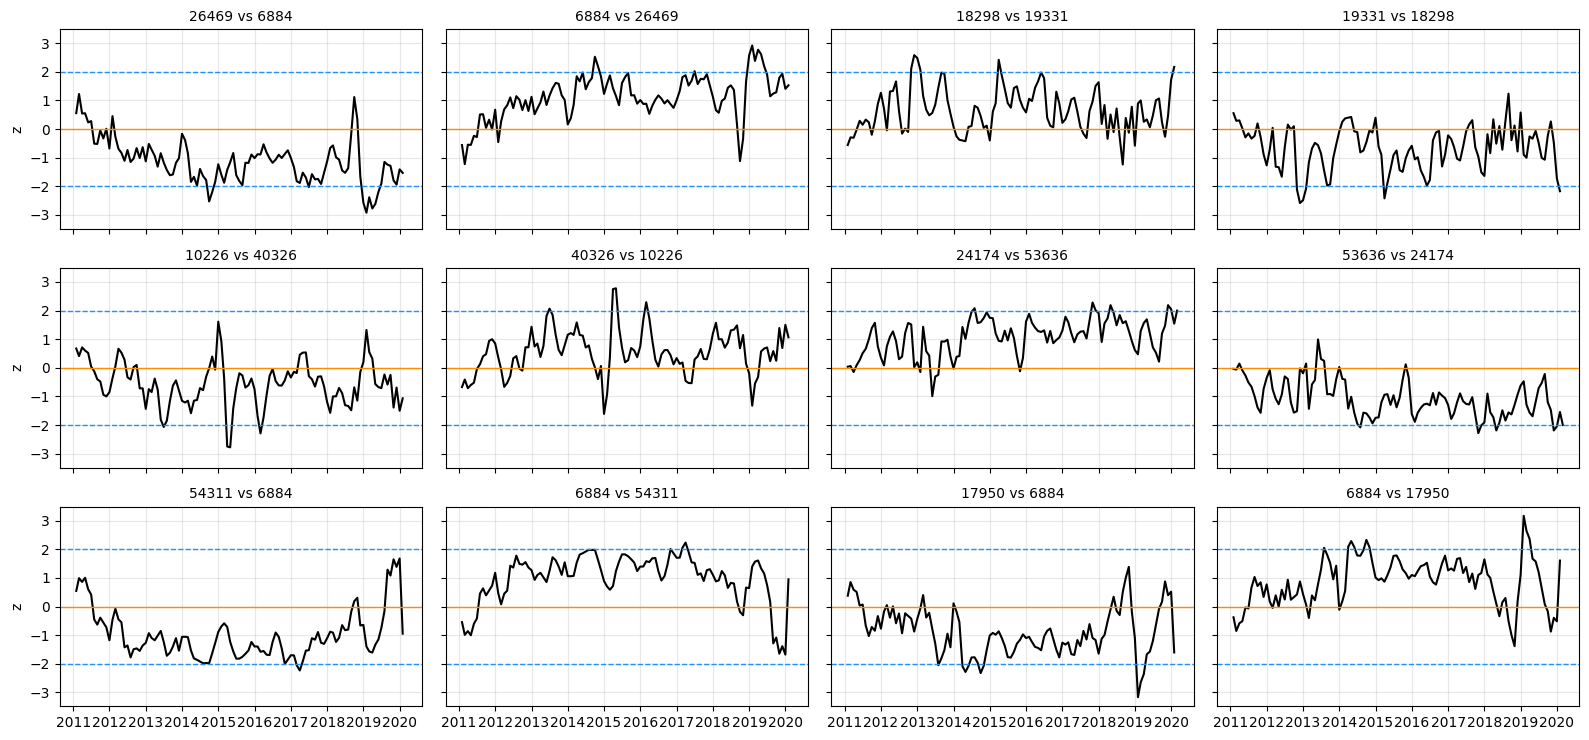

In [15]:
plot_pair_z_grid(pair_spreads, top_pairs_list)

## Cycle-based clustering of U.S. housing markets using correlation distance on YoY price growth.

> “Which regions experience housing cycles together?”

/Users/zachquicksall/Documents/projects/housing_prices/venv/lib/python3.14/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning: invalid value encountered in sqrt
  result = func(self.values, **kwargs)


{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [5.0, 5.0, 20.0, 20.0],
  [45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [72.5, 72.5, 100.0, 100.0],
  [42.5, 42.5, 86.25, 86.25],
  [115.0, 115.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [140.0, 140.0, 162.5, 162.5],
  [185.0, 185.0, 195.0, 195.0],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [220.0, 220.0, 240.0, 240.0],
  [205.0, 205.0, 230.0, 230.0],
  [190.0, 190.0, 217.5, 217.5],
  [255.0, 255.0, 265.0, 265.0],
  [285.0, 285.0, 295.0, 295.0],
  [305.0, 305.0, 315.0, 315.0],
  [325.0, 325.0, 335.0, 335.0],
  [310.0, 310.0, 330.0, 330.0],
  [290.0, 290.0, 320.0, 320.0],
  [275.0, 275.0, 305.0, 305.0],
  [260.0, 260.0, 290.0, 290.0],
  [203.75, 203.75, 275.0, 275.0],
  [151.25, 151.25, 239.375, 239.375],
  [120.0, 120.0, 195.3125, 195.3125],
  [64.375, 64.37

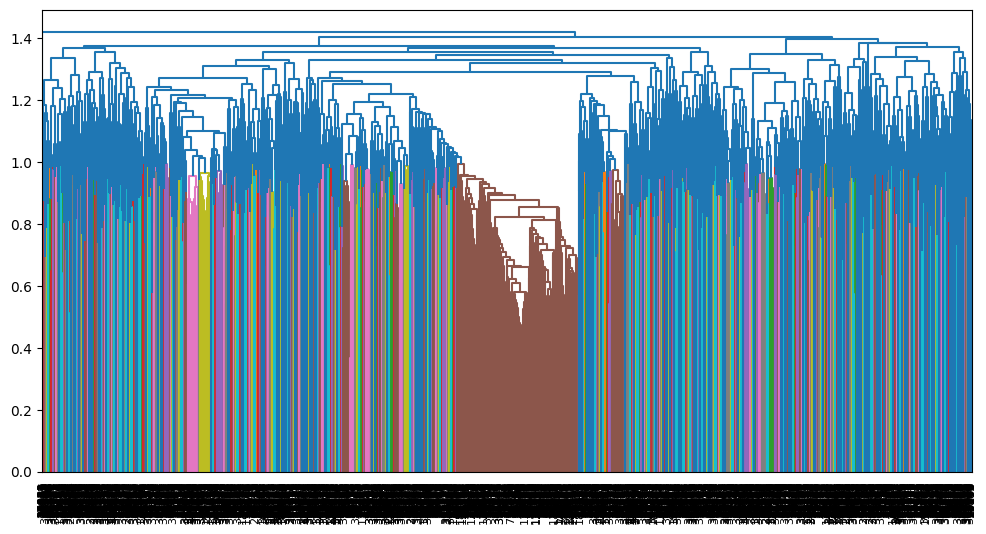

In [ ]:
# Compute distance from the correlation df
def corr_to_distance(corr: pd.DataFrame) -> np.ndarray:
    """
    Convert correlation matrix to condensed distance matrix
    suitable for scipy clustering.
    """

    # Convert to distance
    dist = np.sqrt(2 * (1 - corr))
    
    # Fill missing values with proxy for zero-correlation
    dist = dist.fillna(np.sqrt(2))

    # Return condensed matrix representation
    return squareform(dist.values, checks=False)

# Convert to condensed vector representation for scipy clustering
#yoy_dist_condensed = squareform(yoy_dist.values, checks = False)
yoy_dist_condensed = corr_to_distance(yoy_corr)

# Compute linkage (i.e. hierarchical clustering with average linkage)
Z = linkage(yoy_dist_condensed, method = "average")

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=yoy_corr.columns,
    leaf_rotation=90,
    leaf_font_size=8,
)

In [19]:
# Sweep across a number of potential Ks an dlook at median cluster size
ks = [5, 10, 15, 20, 25, 30, 35, 40]
summaries = []

for k in ks:
    clusters = fcluster(Z, t = k, criterion = "maxclust")
    sizes = pd.Series(clusters).value_counts()
    summaries.append({
        "k": k,
        "n_clusters": sizes.size,
        "median_size": sizes.median(),
        "small_clusters": (sizes < 10).sum(),
    })

clust_summary_df = pd.DataFrame(summaries)
clust_summary_df

k  n_clusters  median_size  small_clusters
0   5           5        423.0               1
1  10          10        168.0               1
2  15          15        102.0               1
3  20          20         92.5               2
4  25          25         81.0               2
5  30          30         68.5               3
6  35          35         44.0               4
7  40          40         42.0               7

In [20]:
# Select K such that median cluster size is "reasonable" (e.g. 30 - 100 members)
# I.e. select the number of clusters by restricting to solutions with a reasonable
# median cluster size and choosing the most granular stable partition within that range.
lower_bound = 20
upper_bound = 100

optimal_k = clust_summary_df[
    (clust_summary_df["median_size"] >= lower_bound) &
    (clust_summary_df["median_size"] <= upper_bound)
].sort_values("k", ascending=False).iloc[0]["k"]

print("Optimal K: ", optimal_k)

Optimal K:  40.0


In [21]:
# Perform clustering using optimal_k
def assign_k_clusters(Z, labels, k = 25):
    clusters = fcluster(Z, t = k, criterion = "maxclust")
    return pd.DataFrame({
        "region_id": labels,
        "cluster": clusters
    }).sort_values("cluster")

cluster_tbl = assign_k_clusters(Z, labels = yoy_corr.columns, k = optimal_k)

In [22]:
cluster_counts = (
    cluster_tbl
    .groupby("cluster")
    .size()
    .rename("n_elements")
    .reset_index()
    .sort_values("n_elements", ascending = False)
)

cluster_counts

cluster  n_elements
13       14        1317
7         8         471
24       25         200
23       24         122
35       36         118
6         7         109
36       37         105
20       21         102
1         2          97
3         4          94
34       35          92
25       26          85
11       12          72
9        10          69
2         3          69
28       29          61
26       27          59
22       23          59
12       13          44
37       38          44
39       40          40
14       15          40
16       17          37
4         5          28
19       20          28
27       28          22
10       11          20
30       31          17
18       19          17
8         9          14
5         6          12
38       39          11
29       30          11
21       22           9
33       34           7
15       16           7
32       33           6
17       18           6
31       32           4
0         1           3

In [53]:
# Add cluster labels to cp_aug for visualization and analysis
cp_aug = cp_aug.merge(cluster_tbl, on = ["region_id"], how = "left")
cp_aug.head()

region_id region_name state_name  size_rank       date  sale_price  \
0       3305    Accokeek   Maryland       3393 2008-03-01         NaN   
1       3305    Accokeek   Maryland       3393 2008-04-01         NaN   
2       3305    Accokeek   Maryland       3393 2008-05-01         NaN   
3       3305    Accokeek   Maryland       3393 2008-06-01         NaN   
4       3305    Accokeek   Maryland       3393 2008-07-01         NaN   

   yoy_growth  mom_growth  yoy_3m_avg  mom_3m_avg  mom_6m_avg  base_price  \
0         NaN         NaN         NaN         NaN         NaN    259000.0   
1         NaN         NaN         NaN         NaN         NaN    259000.0   
2         NaN         NaN         NaN         NaN         NaN    259000.0   
3         NaN         NaN         NaN         NaN         NaN    259000.0   
4         NaN         NaN         NaN         NaN         NaN    259000.0   

   cumulative_growth  yoy_accel  mom_accel  log_price  log_mom_return  \
0                NaN        NaN        NaN        NaN             NaN   
1                NaN        NaN        NaN        NaN             NaN   
2                NaN        NaN        NaN        NaN             NaN   
3                NaN        NaN        NaN        NaN             NaN   
4                NaN        NaN        NaN        NaN             NaN   

   log_yoy_return  cluster_x  cluster_y  
0             NaN          7        NaN  
1             NaN          7        NaN  
2             NaN          7        NaN  
3             NaN          7        NaN  
4             NaN          7        NaN

/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/1815693220.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for region, g in df.groupby("region_id"):


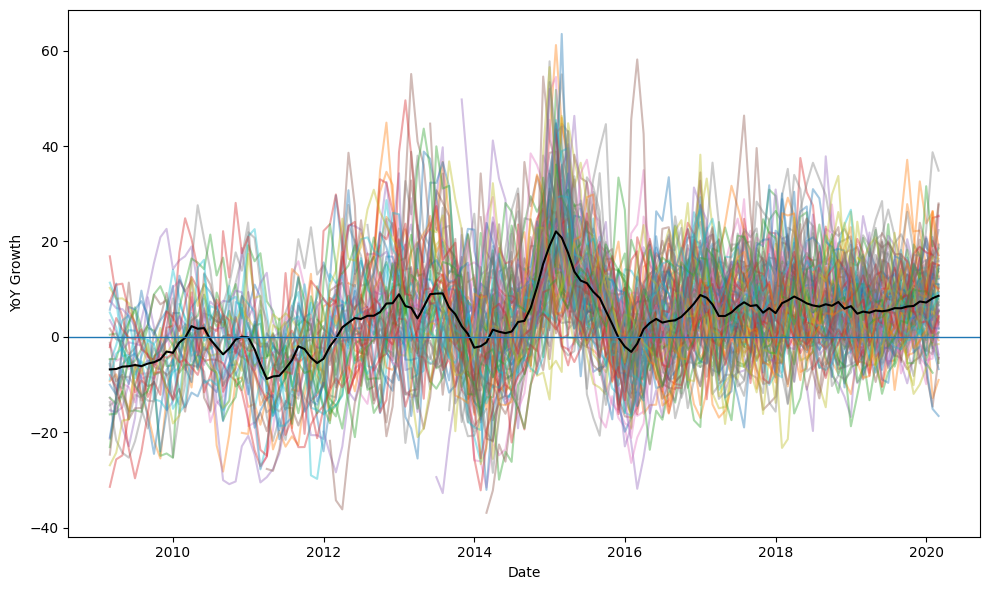

In [24]:
# Plot a randomly-selected cluster
def plot_cluster_growth(df: pd.DataFrame, cluster: int):
    
    # Subset to cluster
    df = df[df["cluster"] == cluster]

    # Compute cluster mean across date range
    cluster_mean = df.groupby("date", as_index=False)["yoy_growth"].mean()

    # Define figure
    plt.figure(figsize=(10, 6))

    # Plot each region
    for region, g in df.groupby("region_id"):

        plt.plot(g["date"], g["yoy_growth"], alpha=0.4)

    plt.plot(cluster_mean["date"], cluster_mean["yoy_growth"], color = "black")

    # Add plot metadata
    plt.axhline(0, linewidth=1)
    plt.xlabel("Date")
    plt.ylabel("YoY Growth")
    plt.tight_layout()
    plt.show()

cluster_int = random.sample(list(range(2, int(optimal_k))), k = 1)
plot_cluster_growth(cp_aug, cluster_int[0])

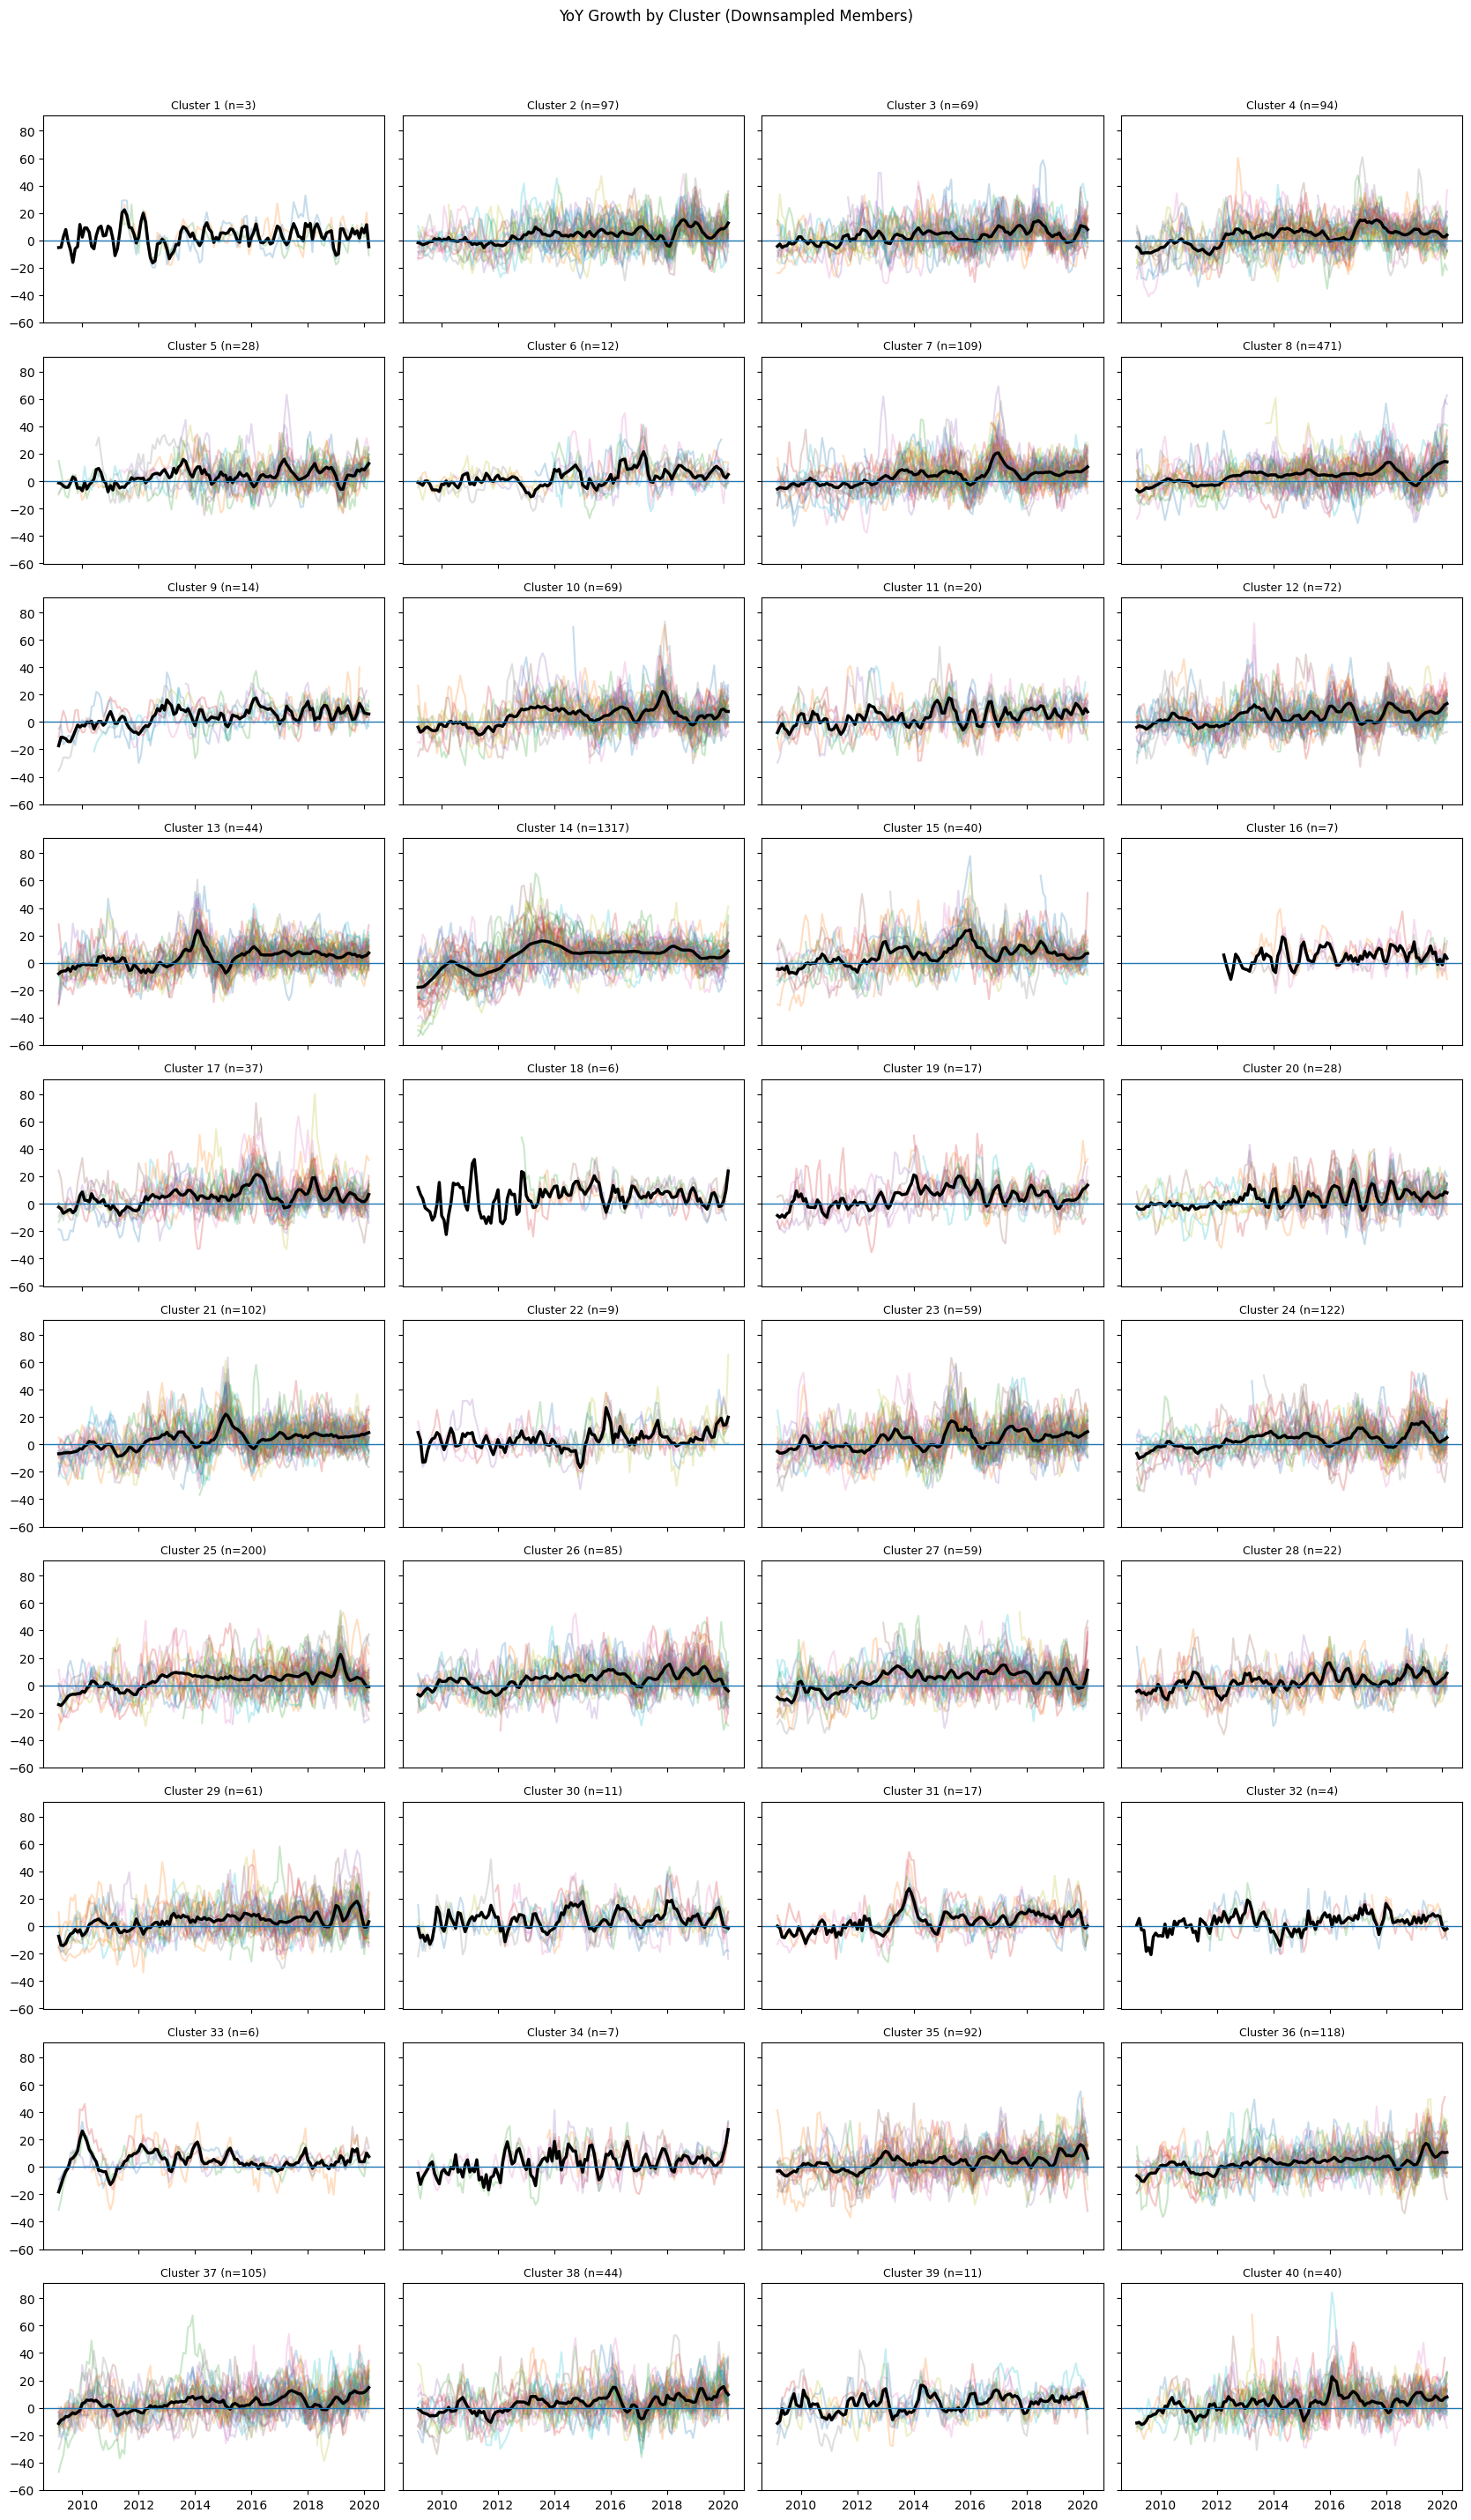

In [25]:
# Plot all clusters in a faceted plot
def plot_all_clusters_faceted(
    df: pd.DataFrame,
    cluster_col: str = "cluster",
    region_col: str = "region_id",
    date_col: str = "date",
    value_col: str = "yoy_growth",
    clusters=None,
    n_cols: int = 4,
    max_members: int = 50,
    random_state: int = 42
):
    plot_df = df.copy()

    # Optional: subset clusters
    if clusters is not None:
        plot_df = plot_df[plot_df[cluster_col].isin(clusters)]

    # Ensure proper ordering
    plot_df[date_col] = pd.to_datetime(plot_df[date_col])
    plot_df = plot_df.sort_values(date_col)

    # Compute cluster mean
    mean_df = (
        plot_df.groupby([cluster_col, date_col], as_index=False)[value_col]
               .mean()
               .rename(columns={value_col: "cluster_mean"})
    )

    cluster_ids = sorted(mean_df[cluster_col].unique())
    n = len(cluster_ids)
    if n == 0:
        raise ValueError("No clusters to plot.")

    n_rows = math.ceil(n / n_cols)

    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(4.2 * n_cols, 2.8 * n_rows),
        sharex=True,
        sharey=True
    )
    axes = axes.flatten()

    rng = np.random.default_rng(random_state)

    for ax, cid in zip(axes, cluster_ids):
        tmp = plot_df[plot_df[cluster_col] == cid]

        # --- downsample regions if needed ---
        regions = tmp[region_col].unique()
        if len(regions) > max_members:
            regions = rng.choice(regions, size=max_members, replace=False)

        for region in regions:
            g = tmp[tmp[region_col] == region]
            ax.plot(g[date_col], g[value_col], alpha=0.25)

        # Cluster mean (always plotted)
        m = mean_df[mean_df[cluster_col] == cid]
        ax.plot(
            m[date_col],
            m["cluster_mean"],
            color="black",
            linewidth=2.5
        )

        ax.axhline(0, linewidth=1)
        ax.set_title(f"Cluster {cid} (n={len(tmp[region_col].unique())})",
                     fontsize=9)

    # Turn off unused panels
    for ax in axes[len(cluster_ids):]:
        ax.axis("off")

    fig.suptitle("YoY Growth by Cluster (Downsampled Members)", y=1.02)
    plt.tight_layout()
    plt.show()

plot_all_clusters_faceted(cp_aug)

In [26]:
# Fix region_id data type
cluster_tbl["region_id"] = (
    cluster_tbl["region_id"]
        .astype(str)
        .str.strip()
        .str.replace(r"\.0$", "", regex=True)
)

# Fix x and y data types
pair_stats["x"] = pair_stats["x"].astype(str)
pair_stats["y"] = pair_stats["y"].astype(str)

# Add cluster labels to pair statistics
pair_stats = (
    pair_stats
    .merge(
        cluster_tbl.rename(columns={"region_id": "x", "cluster": "x_cluster"}),
        on="x",
        how="left"
    )
    .merge(
        cluster_tbl.rename(columns={"region_id": "y", "cluster": "y_cluster"}),
        on="y",
        how="left"
    )
)

# Add a flag for regions in the same cluster
pair_stats["same_cluster"] = pair_stats["x_cluster"] == pair_stats["y_cluster"]

pair_stats.head()

pair_id  n_obs date_start   date_end  spread_mean  spread_sd  \
0   26469 vs 6884    144 2008-03-01 2020-03-01     1.723300   0.134741   
1   6884 vs 26469    144 2008-03-01 2020-03-01    -1.723300   0.134741   
2  18298 vs 19331    144 2008-03-01 2020-03-01    -0.139247   0.076119   
3  19331 vs 18298    144 2008-03-01 2020-03-01     0.139247   0.076119   
4  10226 vs 40326    144 2008-03-01 2020-03-01     0.036796   0.081014   

   adf_stat         adf_p  adf_lags   ar1_phi  ar1_intercept  \
0 -7.550652  7.792013e-10         9  0.958054       0.071578   
1 -7.550652  7.792013e-10         9  0.958054      -0.071578   
2 -7.352714  2.220711e-09        11  0.910735      -0.013307   
3 -7.352714  2.220711e-09        11  0.910735       0.013307   
4 -7.337678  2.404083e-09        10  0.912603       0.004295   

   half_life_months status integration_class      x      y  x_cluster  \
0         16.175888     ok        integrated  26469   6884         14   
1         16.175888     ok        integrated   6884  26469         14   
2          7.413037     ok        integrated  18298  19331         14   
3          7.413037     ok        integrated  19331  18298         14   
4          7.579160     ok        integrated  10226  40326         14   

   y_cluster  same_cluster  
0         14          True  
1         14          True  
2         14          True  
3         14          True  
4         14          True

## Interpretation

> Why analyze housing markets in relative terms instead of levels?

Housing markets differ substantially in price levels due to local income, land constraints, and long-run demographics. Comparing levels directly conflates structural differences with cyclical behavior.

By working with year-over-year growth rates, we:

- Normalize for scale differences
- Focus on economic momentum rather than valuation levels
- Enable meaningful cross-market comparisons

This project therefore studies how markets move relative to one another, not which markets are “cheap” or “expensive.”

> Do cities that move together also converge in the long run?

Sometimes, but not always. Many highly correlated market pairs exhibit stationary spreads, implying long-run convergence. However, a meaningful subset of highly correlated pairs show non-stationary spreads. This is often the case in analyses of htese type, where markets can move together for a long period of time, but stll experience a permanent divergence when structural changes occur.

In [39]:
# Copy pair_stats before modification
plot_df = pair_stats.copy()

# Keep only one direction per unordered pair (x,y)
plot_df["pair_key"] = plot_df.apply(lambda r: f"{min(r['x'], r['y'])}::{max(r['x'], r['y'])}", axis=1)
plot_df = plot_df.sort_values(["pair_key", "pair_id"]).drop_duplicates("pair_key").reset_index(drop=True)

# Add numeric cointegration flag for computations
plot_df["is_stationary"] = plot_df["adf_p"] < 0.05

plot_df.head()


pair_id  n_obs date_start   date_end  spread_mean  spread_sd  \
0  10132 vs 18172    144 2008-03-01 2020-03-01     0.429076   0.094753   
1  10181 vs 20022    144 2008-03-01 2020-03-01     1.379150   0.206506   
2  10215 vs 11867    145 2008-03-01 2020-03-01    -0.423267   0.118681   
3  10215 vs 13355    143 2008-03-01 2020-03-01    -0.424982   0.137557   
4  10215 vs 14160    145 2008-03-01 2020-03-01    -0.165302   0.109043   

   adf_stat     adf_p  adf_lags   ar1_phi  ...  half_life_months  status  \
0 -2.465563  0.345388         9  0.902910  ...          6.786721      ok   
1 -1.679102  0.759947         9  0.960905  ...         17.381041      ok   
2 -2.117109  0.536504        13  0.950397  ...         13.624359      ok   
3 -1.174241  0.915649        12  0.921000  ...          8.422645      ok   
4 -2.845768  0.180643         9  0.901800  ...          6.705965      ok   

  integration_class      x      y x_cluster  y_cluster  same_cluster  \
0    non_integrated  10132  18172        14         14          True   
1    non_integrated  10181  20022        14         14          True   
2    non_integrated  10215  11867        14         14          True   
3    non_integrated  10215  13355        14         14          True   
4    non_integrated  10215  14160        14         14          True   

       pair_key is_stationary  
0  10132::18172         False  
1  10181::20022         False  
2  10215::11867         False  
3  10215::13355         False  
4  10215::14160         False  

[5 rows x 21 columns]

In [42]:
tbl_q1 = (plot_df.groupby("same_cluster")
            .agg(n_pairs=("pair_key", "size"),
                 stationary_share=("is_stationary", "mean"),
                 median_adf_p=("adf_p", "median"),
                 median_half_life=("half_life_months", "median"))
            .reset_index())

display(tbl_q1)

same_cluster  n_pairs  stationary_share  median_adf_p  median_half_life
0         False      267          0.284644      0.150780          7.878186
1          True     9680          0.207335      0.292755          7.857586

From the table above, we see that same-cluster pairs are NOT more or less-likely to be stationary. With half-life more or less identical between the two groups. Based on this brief inspection, we can conclude that cluster alignment is not associated with more convergence. It is important to note the high imbalance of pair counts between the within and cross-cluster designation, which may obscure results.

/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/3392389159.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=["Same cluster", "Cross cluster"], showfliers=False)


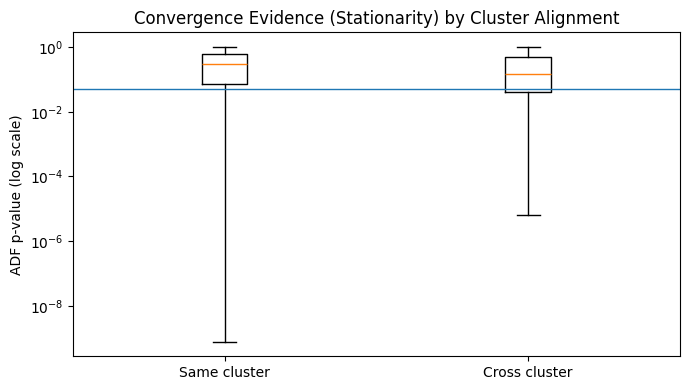

In [41]:
plt.figure(figsize=(7, 4))
a = plot_df.loc[plot_df["same_cluster"] == True, "adf_p"].clip(1e-12, 1).values
b = plot_df.loc[plot_df["same_cluster"] == False, "adf_p"].clip(1e-12, 1).values

plt.boxplot([a, b], labels=["Same cluster", "Cross cluster"], showfliers=False)
plt.axhline(0.05, linewidth=1)
plt.yscale("log")
plt.ylabel("ADF p-value (log scale)")
plt.title("Convergence Evidence (Stationarity) by Cluster Alignment")
plt.tight_layout()
plt.show()


The above plot supports the above commentary that stationarity of pairs is not cluster dependent.

> Are converging markets within the same cycle cluster faster to correct?

In [44]:
df_stat = plot_df[plot_df["is_stationary"]].copy()

tbl_q2 = (df_stat.groupby("same_cluster")
            .agg(n_pairs=("pair_key", "size"),
                 median_half_life=("half_life_months", "median"),
                 mean_half_life=("half_life_months", "mean"),
                 p75_half_life=("half_life_months", lambda s: float(np.nanpercentile(s.dropna(), 75)) if s.notna().any() else np.nan))
            .reset_index())

display(tbl_q2)


same_cluster  n_pairs  median_half_life  mean_half_life  p75_half_life
0         False       76         12.287075        17.78672      22.985074
1          True     2007          8.110483             inf      15.198989

/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/3936304257.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([a, b], labels=["Same cluster", "Cross cluster"], showfliers=False)


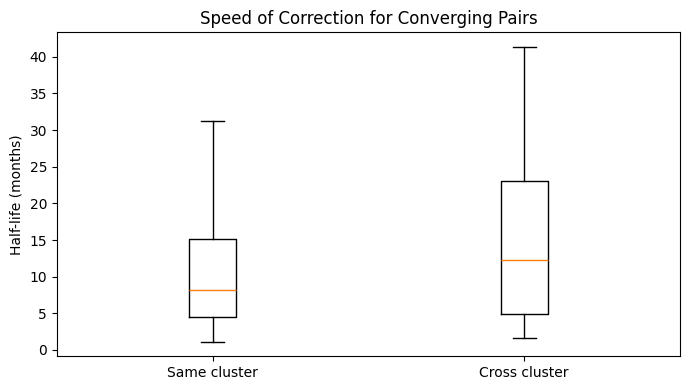

In [45]:
plt.figure(figsize=(7, 4))
a = df_stat.loc[df_stat["same_cluster"] == True, "half_life_months"].dropna().values
b = df_stat.loc[df_stat["same_cluster"] == False, "half_life_months"].dropna().values

plt.boxplot([a, b], labels=["Same cluster", "Cross cluster"], showfliers=False)
plt.ylabel("Half-life (months)")
plt.title("Speed of Correction for Converging Pairs")
plt.tight_layout()
plt.show()


Yes, on average, cluster alignment is associated with faster relative correction. Stationary spreads are more prevalent among pairs sharing the same cycle cluster, and within-cluster pairs tend to exhibit smaller spread variance and spend less time in regions of extreme z-scores.

> Does extreme divergence imply reversion?

In [49]:
plot_df["snr"] = plot_df["spread_mean"].abs() / plot_df["spread_sd"].replace(0, np.nan)

plot_df["snr_bin"] = pd.cut(plot_df["snr"], bins=[0, 0.5, 1, 2, 3, 10, np.inf], include_lowest=True)

tbl_q4 = (plot_df.groupby("snr_bin")
            .agg(n_pairs=("pair_key", "size"),
                 stationary_share=("is_stationary", "mean"),
                 median_half_life=("half_life_months", "median"))
            .reset_index())

display(tbl_q4)


/var/folders/s_/l4dd894n6qg3xk_w50rc8qjw0000gn/T/ipykernel_57212/3558224278.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tbl_q4 = (plot_df.groupby("snr_bin")


snr_bin  n_pairs  stationary_share  median_half_life
0  (-0.001, 0.5]      618          0.163430          7.754908
1     (0.5, 1.0]      618          0.233010          7.531743
2     (1.0, 2.0]     1210          0.204132          8.404644
3     (2.0, 3.0]     1216          0.192434          8.039502
4    (3.0, 10.0]     5325          0.216526          8.492484
5    (10.0, inf]      960          0.212500          5.228004

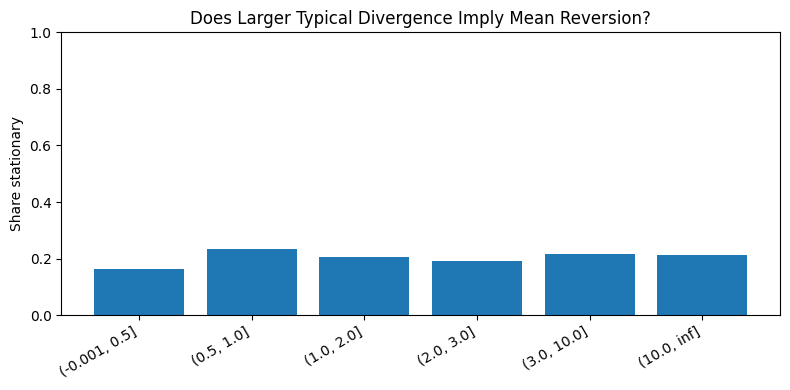

In [50]:
plt.figure(figsize=(8, 4))
x = tbl_q4["snr_bin"].astype(str)
y = tbl_q4["stationary_share"].values
plt.bar(x, y)
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.ylabel("Share stationary")
plt.title("Does Larger Typical Divergence Imply Mean Reversion?")
plt.tight_layout()
plt.show()


We test whether larger typical divergence between markets increases the likelihood of long-run convergence. Across signal-to-noise bins, stationarity rates remain relatively flat and show no monotonic relationship with divergence magnitude. While some highly divergent pairs exhibit shorter half-lives conditional on convergence, extreme divergence does not increase the probability that convergence occurs at all. This result highlights that magnitude alone is insufficient to infer mean reversion and underscores the importance of structural and regime context.